In [1]:
from pathlib import Path
from utils.data_loader import load_crime_dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Location of stored dataset
dataset_path = Path('../datasets/chicago-crime-data.csv')

if dataset_path.exists():
    print(f"File found: {dataset_path.name}")
else:
    load_crime_dataset()

File found: chicago-crime-data.csv


In [3]:
# Converting result into dataframe
df = pd.read_csv(dataset_path)
df.head(4)

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,11662417,JC232642,2019-04-21T12:30:00.000,009XX E 80TH ST,031A,ROBBERY,ARMED - HANDGUN,RESIDENCE,False,False,...,8.0,44.0,03,1184044.0,1852159.0,2019,2023-09-14T15:41:59.000,41.749500,-87.601157,"{'latitude': '41.749500329', 'longitude': '-87..."
1,12990873,JG161829,2019-08-17T13:14:00.000,008XX N KARLOV AVE,1751,OFFENSE INVOLVING CHILDREN,CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,True,True,...,37.0,23.0,17,1148899.0,1905351.0,2019,2023-09-14T15:41:59.000,41.896215,-87.728572,"{'latitude': '41.89621515', 'longitude': '-87...."
2,11630496,JC193727,2019-03-16T11:35:00.000,045XX N LINCOLN AVE,0890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,...,47.0,4.0,06,NaN,NaN,2019,2019-03-23T16:03:16.000,NaN,NaN,NaN
3,11632505,JC196841,2019-03-20T01:00:00.000,013XX W HOOD AVE,0810,THEFT,OVER $500,OTHER,False,False,...,48.0,77.0,06,NaN,NaN,2019,2019-03-27T16:10:11.000,NaN,NaN,NaN


In [4]:
df.shape

(1408934, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408934 entries, 0 to 1408933
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1408934 non-null  int64  
 1   case_number           1408934 non-null  object 
 2   date                  1408934 non-null  object 
 3   block                 1408934 non-null  object 
 4   iucr                  1408934 non-null  object 
 5   primary_type          1408934 non-null  object 
 6   description           1408934 non-null  object 
 7   location_description  1401363 non-null  object 
 8   arrest                1408934 non-null  bool   
 9   domestic              1408934 non-null  bool   
 10  beat                  1408934 non-null  int64  
 11  district              1408934 non-null  int64  
 12  ward                  1408886 non-null  float64
 13  community_area        1408931 non-null  float64
 14  fbi_code              1408934 non-

##### 1. Temporal Crime Trends

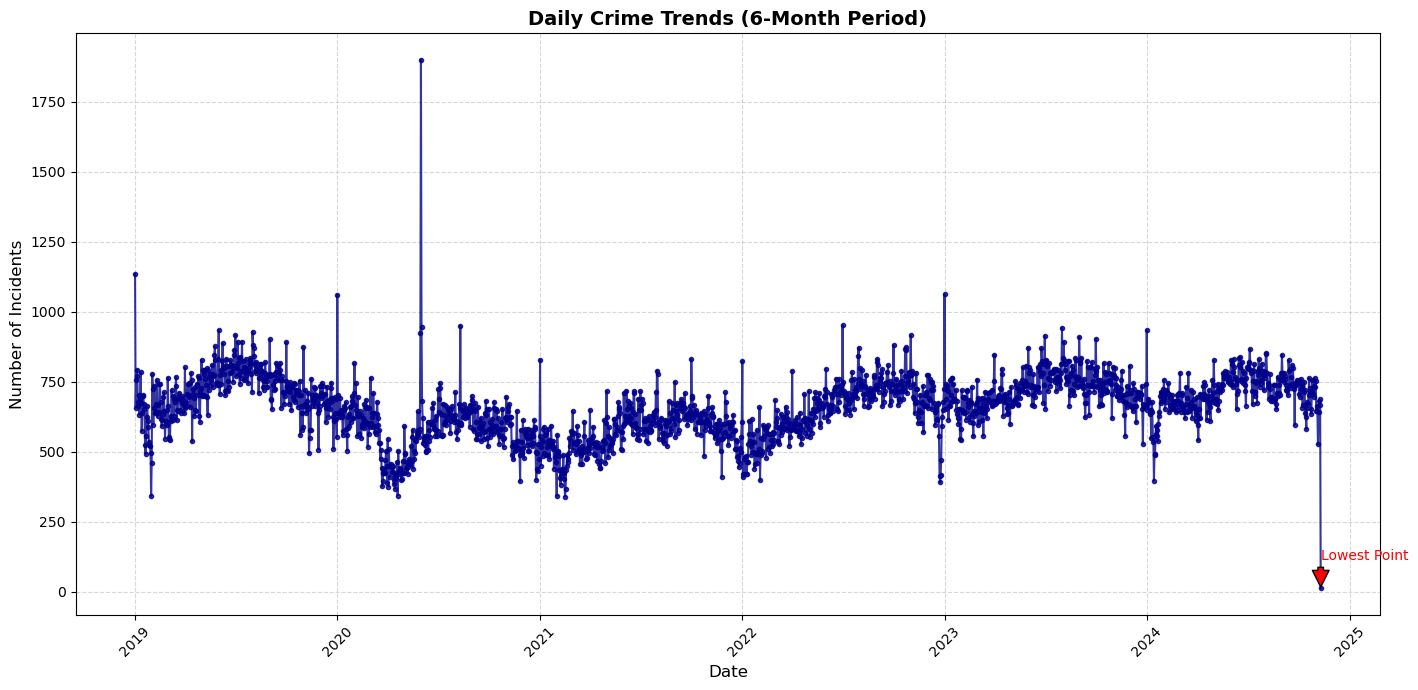

In [6]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Group by the date and count the number of incidents
daily_trends = df.groupby(df['date'].dt.date).size()

# Plot the daily crime trends for the 6-month period
plt.figure(figsize=(14, 7))
plt.plot(daily_trends.index, daily_trends.values, color='darkblue', marker='o', markersize=3, linestyle='-', alpha=0.8)
plt.title('Daily Crime Trends (6-Month Period)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Annotate significant changes, if any
min_value_date = daily_trends.idxmin()
min_value = daily_trends.min()
plt.annotate('Lowest Point', xy=(min_value_date, min_value), xytext=(min_value_date, min_value + 100),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')

plt.show()


<div class="alert alert-block alert-info">
<ul>
<li>
<b>Consitant Crime Rate</b> : The number of incidents remains relatively stable throughout the 6-month period, indicating a steady rate of crime without extreme fluctuations.</li>
<li>
<b>Data Anomaly</b> :  The final data point shows a dramatic decrease, likely suggesting incomplete data rather than an actual decrease in crime incidents.</li>
</ul>
</div>

##### 2. Crime Type Analysis

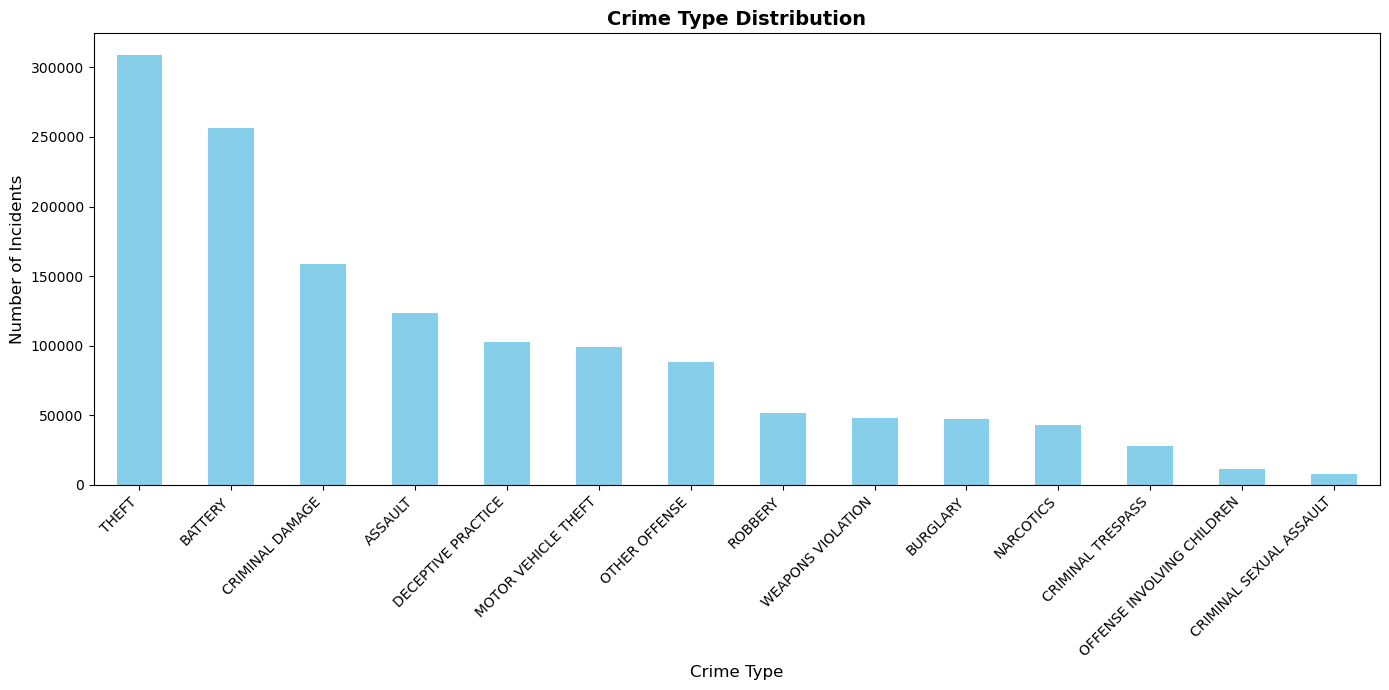

In [7]:
crime_type_counts = df['primary_type'].value_counts().head(14)
plt.figure(figsize=(14, 7))
crime_type_counts.plot(kind='bar', color='skyblue')
plt.title('Crime Type Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Crime Type', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right') 
plt.tight_layout() 
plt.show()

<div class="alert alert-block alert-info">
<ul>
<li>
<b>Theft is the Most Prevalent Crime:</b> :  The highest number of incidents are related to theft, indicating it is a significant issue. Efforts to curb theft could have a substantial impact on overall crime reduction.</li>
<li>
<b>Property Crime vs. Violent Crime: </b> Property-related crimes like theft, damage, and motor vehicle theft appear more frequently than violent crimes. This suggests a focus on property crime prevention strategies may be beneficial.</li>
</ul>
</div>

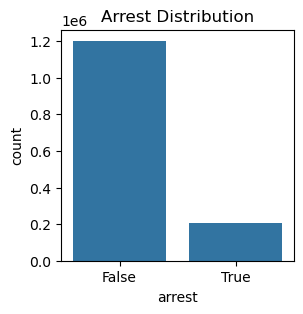

In [8]:
# Arrest analysis
plt.figure(figsize=(3, 3))
sns.countplot(x='arrest', data=df)
plt.title("Arrest Distribution")
plt.show()


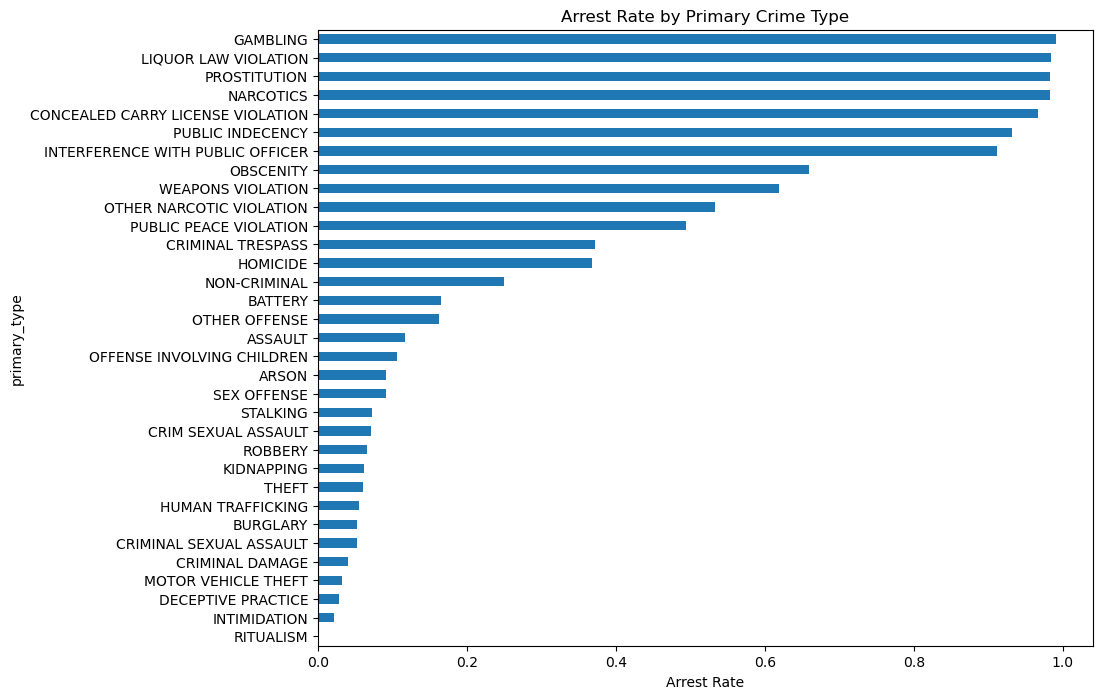

In [9]:
arrest_rate_by_type = df.groupby('primary_type')['arrest'].mean().sort_values()

arrest_rate_by_type.plot(kind='barh', figsize=(10, 8))
plt.title("Arrest Rate by Primary Crime Type")
plt.xlabel("Arrest Rate")
plt.show()


##### 1. Preprocessing & Feature engineering

In [10]:
# Convert 'arrest' to a binary variable (if not already)
df['arrest'] = df['arrest'].astype(int)

# Convert 'date' to datetime and extract time-related features
df['date'] = pd.to_datetime(df['date'])

In [11]:
# Check for missing values
missing=df.isnull().sum()
missing[missing>0]

location_description     7571
ward                       48
community_area              3
x_coordinate            18887
y_coordinate            18887
latitude                18887
longitude               18887
location                18887
dtype: int64

In [12]:
# Check for duplicates
duplicates = df.duplicated().sum()
duplicates

0

In [13]:
df=df.drop(columns=['case_number','id', 'case_number', 'location'],axis=1)


##### Heatmap

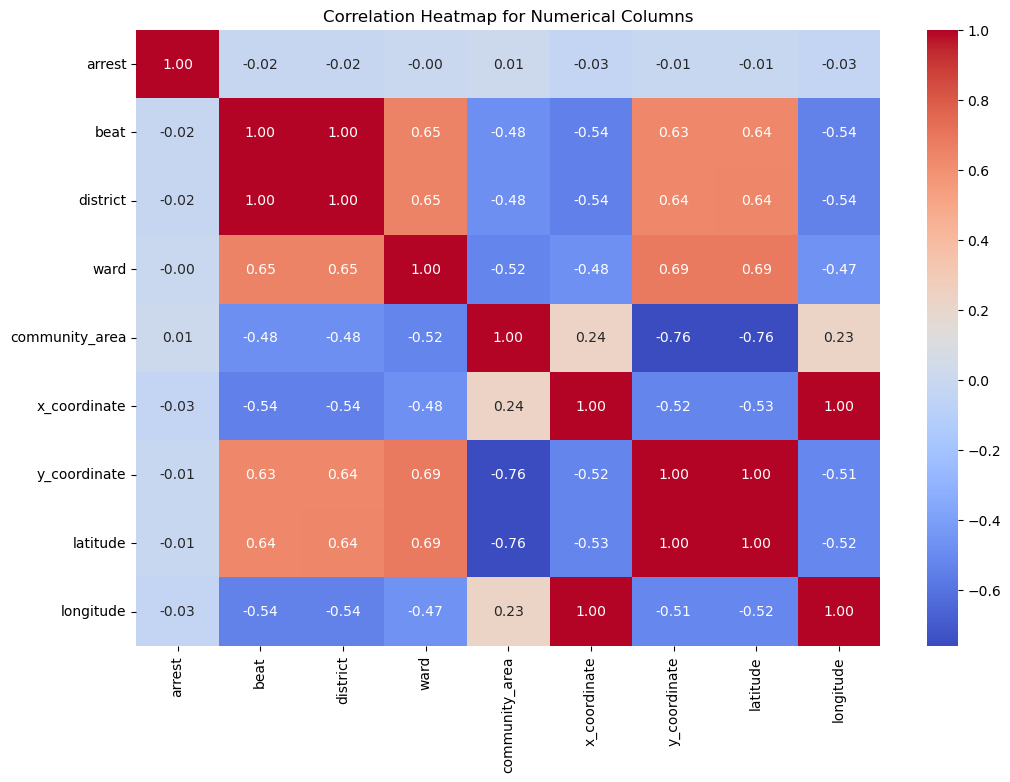

In [14]:
# Correlation Heatmap for Numerical Columns
numerical_columns = ["arrest", "beat", "district", "ward", "community_area", "x_coordinate", "y_coordinate", "latitude", "longitude"]
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap for Numerical Columns")
plt.savefig('heatmap')
plt.show()

<div class="alert alert-block alert-info">
<ul>
<b>Low Correlation with Arrests:</b>

The arrest variable has very low correlation with other numerical features in the dataset (values close to 0), indicating no strong linear relationships.
Features such as beat, district, ward, and geographical coordinates (latitude, longitude, etc.) are not highly predictive of whether an arrest occurs on their own.
</ul>
</div>

##### Pairplot

In [15]:
# # Pairplot for Selected Columns
# selected_columns = ["arrest", "beat", "district", "ward", "latitude", "longitude"]
# sns.pairplot(df[selected_columns].dropna(), diag_kind="kde", markers=".")
# plt.suptitle("Pairplot for Selected Columns", y=1.02)
# plt.show()

#####  Analyzing the relationship between Arrest and Domestic columns

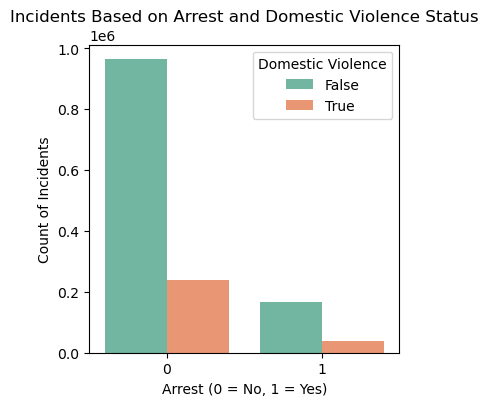

In [16]:

arrest_domestic_counts = df.groupby(['arrest', 'domestic']).size().reset_index(name='count')

# Creating a bar plot to visualize the counts of incidents based on arrest and domestic violence status
plt.figure(figsize=(4, 4))
sns.barplot(data=arrest_domestic_counts, x='arrest', y='count', hue='domestic', palette='Set2')
plt.title("Incidents Based on Arrest and Domestic Violence Status")
plt.xlabel("Arrest (0 = No, 1 = Yes)")
plt.ylabel("Count of Incidents")
plt.legend(title="Domestic Violence")
plt.savefig('bar')
plt.show()


<div class="alert alert-block alert-info">
<ul>

Higher Arrest Likelihood: Incidents involving domestic violence are more likely to result in an arrest than those that do not involve domestic violence.
</div>

##### Data Modelling

In [17]:
from utils.data_preprocessing import preprocess_data

features = ['primary_type','domestic','district','beat','community_area','ward','x_coordinate', 'y_coordinate', 'latitude', 'longitude', 'year']
X = df[features]
X=preprocess_data(X)
y = df['arrest']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




##### Random Forest

In [18]:
# Train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_preds = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))
print("Accuracy:", accuracy_score(y_test, rf_preds))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94    240524
           1       0.66      0.48      0.56     41263

    accuracy                           0.89    281787
   macro avg       0.79      0.72      0.75    281787
weighted avg       0.88      0.89      0.88    281787

Accuracy: 0.888376681678005


##### XGB Classifier

In [ ]:

xgb_model=xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))
print("Accuracy:", accuracy_score(y_test, xgb_preds))


##### Test Hypothesis

###### Hypothesis 1: Domestic crimes have higher arrest rates.

In [ ]:
domestic_arrest_rate = df[df['domestic'] == True]['arrest'].mean()
non_domestic_arrest_rate = df[df['domestic'] == False]['arrest'].mean()

print(f"Domestic Arrest Rate: {domestic_arrest_rate}")
print(f"Non-Domestic Arrest Rate: {non_domestic_arrest_rate}")


###### Hypothesis 2: Violent crimes lead to higher arrests.

In [ ]:
violent_crimes = ['ASSAULT', 'ROBBERY', 'HOMICIDE']  # Example categories
violent_crime_arrest_rate = df[df['primary_type'].isin(violent_crimes)]['arrest'].mean()
non_violent_arrest_rate = df[~df['primary_type'].isin(violent_crimes)]['arrest'].mean()

print(f"Violent Crime Arrest Rate: {violent_crime_arrest_rate}")
print(f"Non-Violent Crime Arrest Rate: {non_violent_arrest_rate}")


###### Hypothesis 3: Certain districts consistently show higher arrest probabilities.


In [ ]:

district_arrest_rate = df.groupby('district')['arrest'].mean()

print(district_arrest_rate.sort_values(ascending=False))
